## **Modelo para predecir si un empleado dejará la compañía**

Uno de los problemas más comunes a los que se enfrenta una empresa es la retención de personal. En este ejercicio se buscará determinar qué factores son los que más afectan la decisión de un empleado para irse de la empresa.

##Descripción de la base de datos 

La base de datos incluye información de 15,000 empleados. Columnas:

* satisfaction_level - Nivel de satisfacción del empleado en porcentaje. 1 es muy staisfecho y 0 es no satisfecho.
* last_evaluation - Tiempo transcurrido desde la última evaluación en años.
* number_project - Número de proyectos en los que está trabajando el empleado.
* average_montly_hours - Promedio de horas trabajadas en los últimos 3 meses.
* time_spend_company = Tiempo en ir y venir al trabajo. Horas a la semana.
* Work_accident - Si el empleado ha tenido un accidente de trabajo. 0 es no ha tenido y 1 si ha tenido.
* left - El empleado ya no trabaja en la compañia. 0 - sigue 1 - se fue.
* promotion_last_5_years - El empleado ha tenido una promoción en los últimos años. 0 - no ha tenido, 1 - si ha tenido.
* Department - Departamento al que pertenece el empleado. Departamentos: support, technical, sales, IT, product_mng, RandD, management, accounting, marketing.
* salary - Nivel de salario. Low, medium & high.

In [2]:
#importar bibliotecas
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

Cargar base y exploración

In [3]:
empleados_todos = pd.read_csv(r"HR_Employee_Data.csv")
empleados_todos.head()

Emp_Id  satisfaction_level  ...  Department  salary
0     IND01                0.33  ...     support     low
1    IND010                0.83  ...   technical     low
2  IND01003                0.80  ...     support  medium
3  IND01006                0.55  ...  management     low
4  IND01009                0.72  ...  management  medium

[5 rows x 11 columns]

In [7]:
empleados_todos.columns

Index(['Emp_Id', 'satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [8]:
empleados_todos.describe()

satisfaction_level  last_evaluation  ...          left  promotion_last_5years
count        15000.000000     15000.000000  ...  15000.000000           15000.000000
mean             0.612841         0.716105  ...      0.238067               0.021333
std              0.248624         0.171164  ...      0.425914               0.144498
min              0.090000         0.360000  ...      0.000000               0.000000
25%              0.440000         0.560000  ...      0.000000               0.000000
50%              0.640000         0.720000  ...      0.000000               0.000000
75%              0.820000         0.870000  ...      0.000000               0.000000
max              1.000000         1.000000  ...      1.000000               1.000000

[8 rows x 8 columns]

In [9]:
empleados_todos.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Emp_Id                 15000 non-null  object 
 1   satisfaction_level     15000 non-null  float64
 2   last_evaluation        15000 non-null  float64
 3   number_project         15000 non-null  int64  
 4   average_montly_hours   15000 non-null  int64  
 5   time_spend_company     15000 non-null  int64  
 6   Work_accident          15000 non-null  int64  
 7   left                   15000 non-null  int64  
 8   promotion_last_5years  15000 non-null  int64  
 9   Department             15000 non-null  object 
 10  salary                 15000 non-null  object 
dtypes: float64(2), int64(6), object(3)
memory usage: 1.3+ MB


In [10]:
# Se borra la columna Emp_Id 
new_empleados = empleados_todos.drop(columns=['Emp_Id'])
new_empleados.head()

satisfaction_level  last_evaluation  ...  Department  salary
0                0.33             0.88  ...     support     low
1                0.83             0.66  ...   technical     low
2                0.80             0.62  ...     support  medium
3                0.55             0.71  ...  management     low
4                0.72             0.69  ...  management  medium

[5 rows x 10 columns]

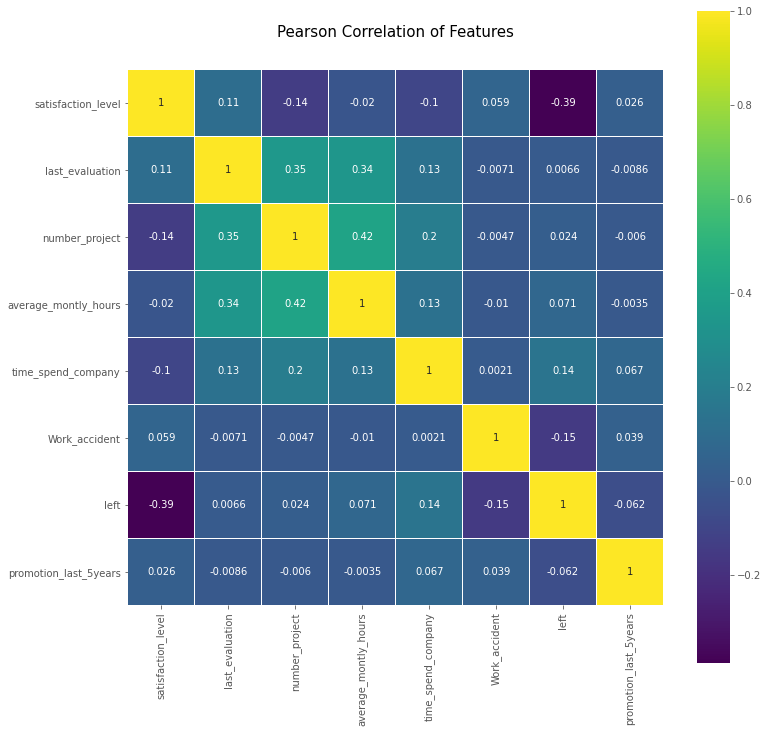

In [11]:
#Calculamos la matriz de correlación
correlation_mat = new_empleados.corr()
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(correlation_mat, linewidths=0.1 , vmax=1.0 , cmap=colormap, square=True, linecolor='white', annot = True)
plt.show()

Las variables que tienen más correlación con "left":
* satisfaction_level: -0.39
* Work_accident: -0.15
* time_spend_company: 0.14
* average_monthly_hours: 0.071
* promotion_last_5years: -0.062
* number_project: 0.024
* last_evaluation: 0.0066








Las variables que tienen más correlación con satisfaction_level (a excepción de left):
last_evaluation: 0.11
number_project: - 0.14
average_monthly_hours: -0.02
time_spend_company: -0.1
Work_accident: 0.059
promotion_last_year: 0.026

In [12]:
new_empleados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     15000 non-null  float64
 1   last_evaluation        15000 non-null  float64
 2   number_project         15000 non-null  int64  
 3   average_montly_hours   15000 non-null  int64  
 4   time_spend_company     15000 non-null  int64  
 5   Work_accident          15000 non-null  int64  
 6   left                   15000 non-null  int64  
 7   promotion_last_5years  15000 non-null  int64  
 8   Department             15000 non-null  object 
 9   salary                 15000 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [13]:
new_empleados['Department_num'] = new_empleados['Department'].apply(lambda x: np.where(new_empleados['Department'].unique()==x)[0][0])
new_empleados.head()

satisfaction_level  last_evaluation  ...  salary  Department_num
0                0.33             0.88  ...     low               0
1                0.83             0.66  ...     low               1
2                0.80             0.62  ...  medium               0
3                0.55             0.71  ...     low               2
4                0.72             0.69  ...  medium               2

[5 rows x 11 columns]

In [14]:
new_empleados['salary_num'] = new_empleados['salary'].apply(lambda x: ['low', 'medium', 'high'].index(x))
new_empleados.head(10)

satisfaction_level  last_evaluation  ...  Department_num  salary_num
0                0.33             0.88  ...               0           0
1                0.83             0.66  ...               1           0
2                0.80             0.62  ...               0           1
3                0.55             0.71  ...               2           0
4                0.72             0.69  ...               2           1
5                0.84             0.98  ...               3           0
6                0.52             0.98  ...               4           1
7                0.87             0.90  ...               0           0
8                0.50             0.63  ...               3           1
9                0.15             0.67  ...               3           1

[10 rows x 12 columns]

In [15]:
empleados_num = new_empleados.drop(columns=['Department', 'salary'])
empleados_num.head()

satisfaction_level  last_evaluation  ...  Department_num  salary_num
0                0.33             0.88  ...               0           0
1                0.83             0.66  ...               1           0
2                0.80             0.62  ...               0           1
3                0.55             0.71  ...               2           0
4                0.72             0.69  ...               2           1

[5 rows x 10 columns]

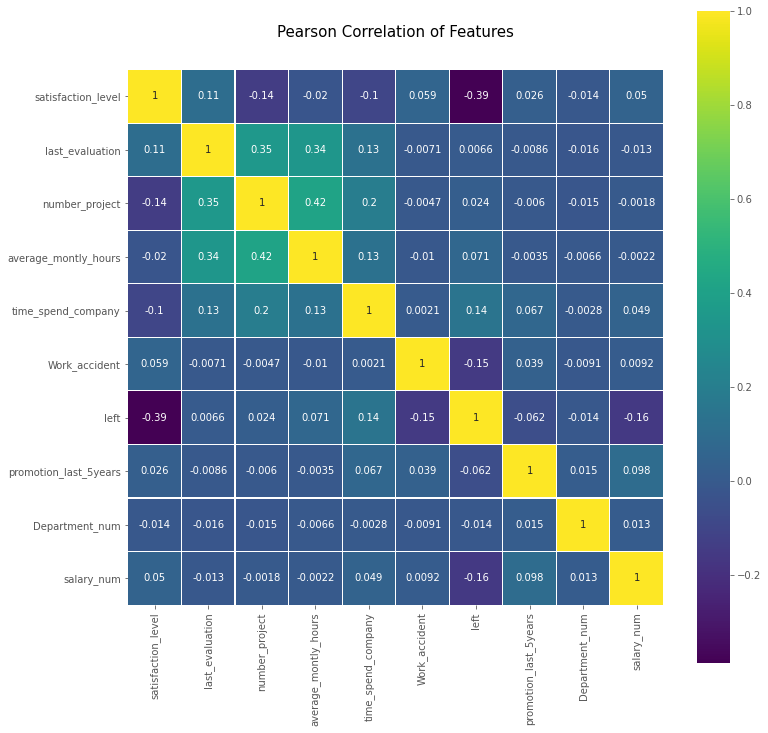

In [16]:
#Calculamos la matriz de correlación
correlation_mat = empleados_num.corr()
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(correlation_mat, linewidths=0.1 , cmap=colormap, vmax=1.0 , square=True, linecolor='white', annot = True)
plt.show()

Las variables que tienen más correlación con "left":

* satisfaction_level: - 0.39
* salary: -0.16
* Work_accident: -0.15
* time_spend_company: 0.14
* average_monthly_hours: 0.071
* promotion_last_5years: - 0.062
* number_project: 0.024
* Department: - 0.014
* last_evaluation: 0.0066

Las variables que tienen más correlación con satisfaction_level (a excepción de left): 

* number_project: - 0.14
* Department: -0.014
* last_evaluation: 0.11
* time_spend_company: -0.1 
* Work_accident: 0.059 
* promotion_last_5years: 0.026
* salary: 0.05
* average_monthly_hours: -0.02 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f15aae13510>]],
      dtype=object)

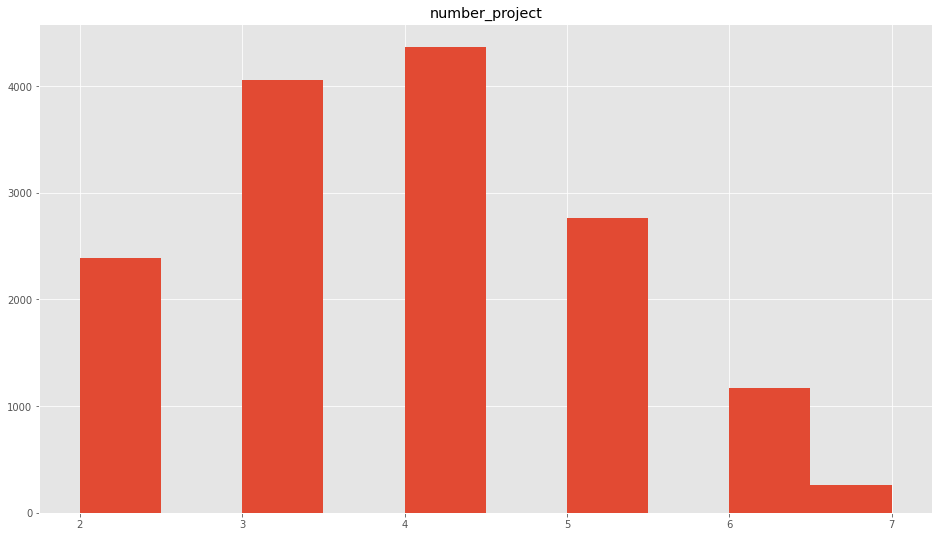

In [19]:
new_empleados.hist(column='number_project')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f15aad9b750>]],
      dtype=object)

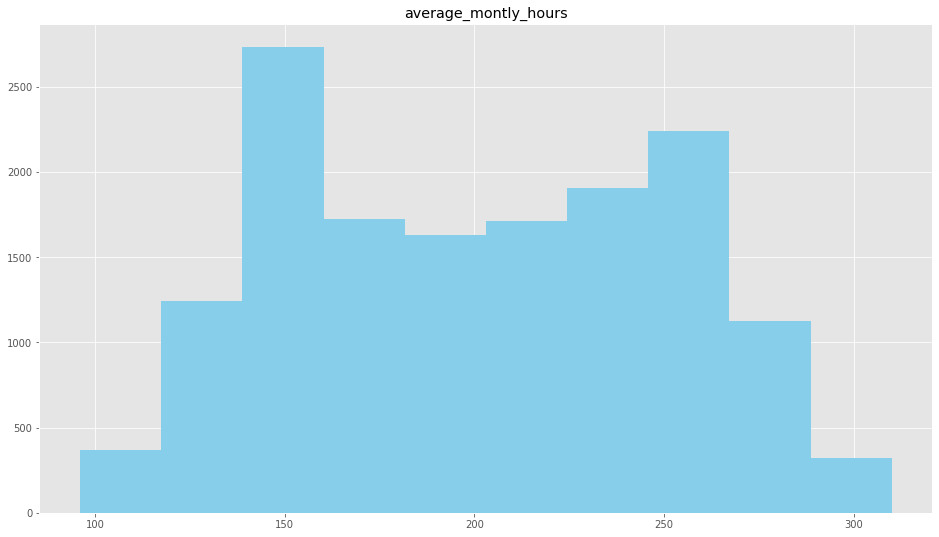

In [20]:
new_empleados.hist(column='average_montly_hours', color = "skyblue")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f15aac27890>]],
      dtype=object)

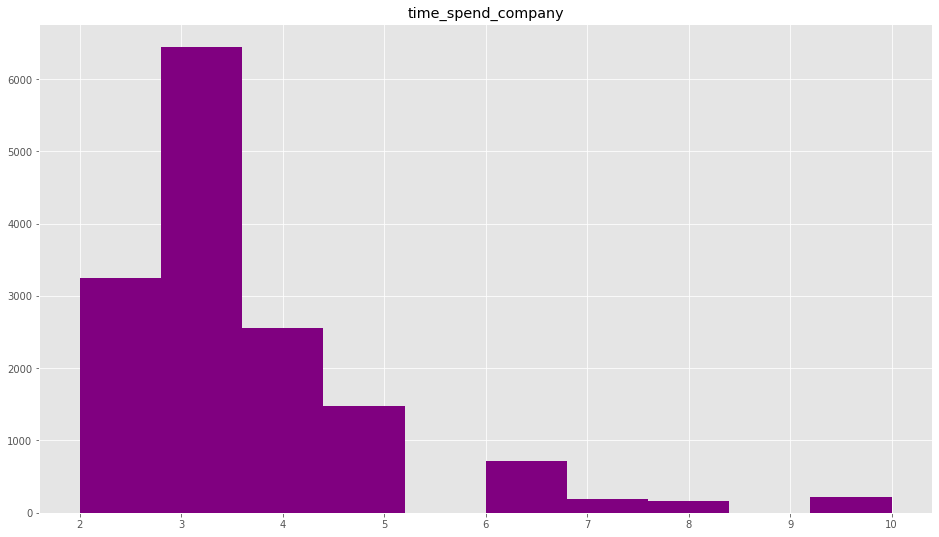

In [21]:
new_empleados.hist(column='time_spend_company', color="purple")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f15aab62d90>]],
      dtype=object)

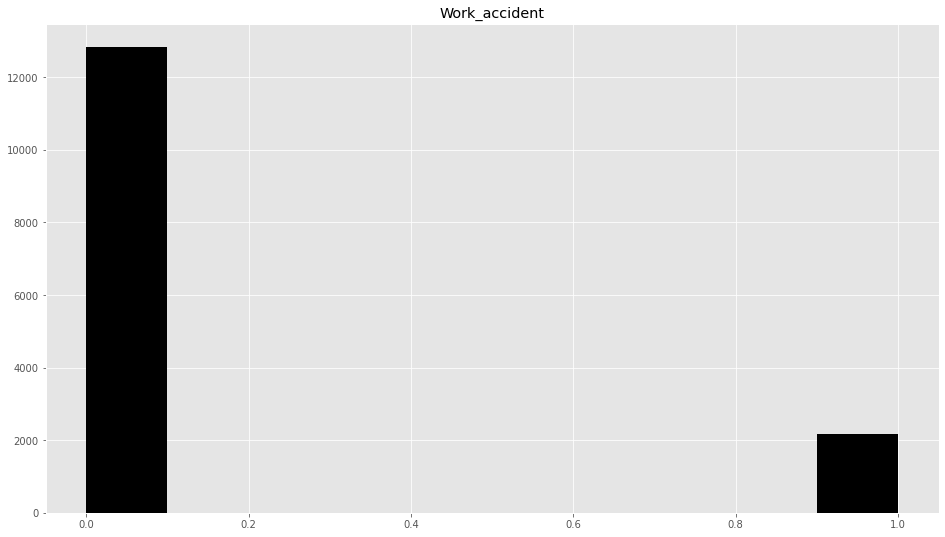

In [24]:
new_empleados.hist(column='Work_accident', color = "black")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f15aab53b50>]],
      dtype=object)

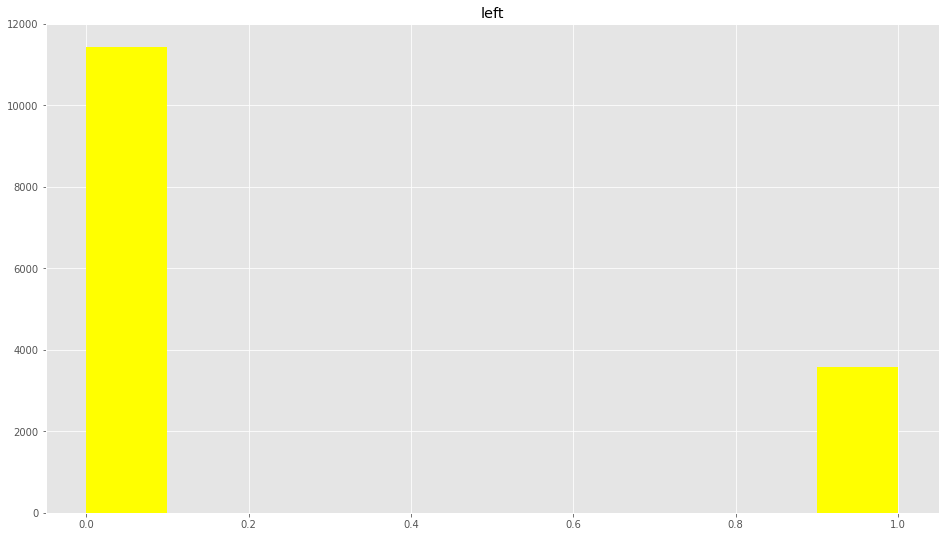

In [25]:
new_empleados.hist(column='left', color='yellow')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f15aa97ac50>]],
      dtype=object)

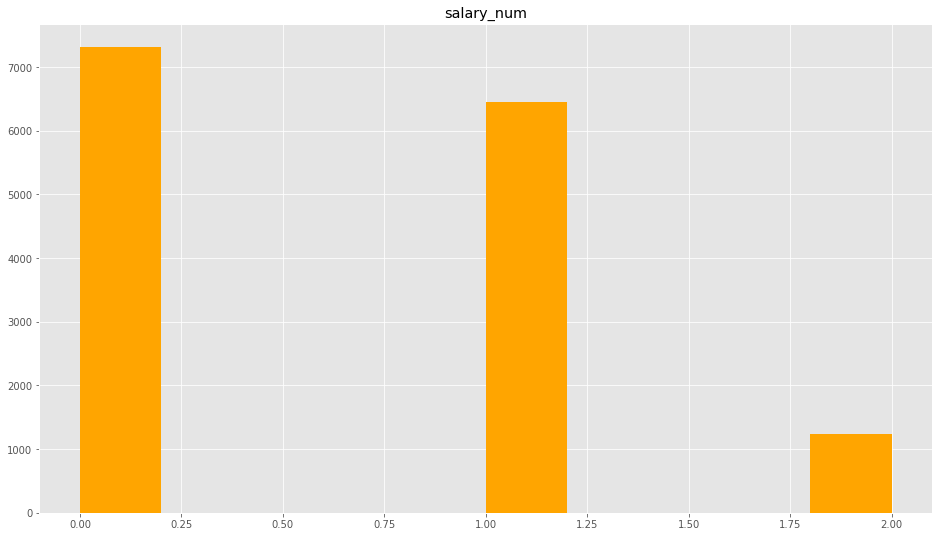

In [27]:
new_empleados.hist(column='salary_num', color = 'orange')

In [ ]:
empleados_num.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department_num', 'salary_num'],
      dtype='object')

In [ ]:
empleados_num[['satisfaction_level', 'left']].groupby(['satisfaction_level'], as_index=False).agg(['mean', 'count', 'sum'])

left           
                        mean count  sum
satisfaction_level                     
0.09                1.000000   195  195
0.10                1.000000   358  358
0.11                1.000000   335  335
0.12                0.133333    30    4
0.13                0.055556    54    3
...                      ...   ...  ...
0.96                0.000000   203    0
0.97                0.000000   176    0
0.98                0.000000   183    0
0.99                0.000000   172    0
1.00                0.000000   111    0

[92 rows x 3 columns]

In [ ]:
empleados_num[['last_evaluation', 'left']].groupby(['last_evaluation'], as_index=False).agg(['mean', 'count', 'sum'])

left           
                     mean count  sum
last_evaluation                     
0.36             0.000000    22    0
0.37             0.000000    55    0
0.38             0.000000    50    0
0.39             0.000000    52    0
0.40             0.000000    57    0
...                   ...   ...  ...
0.96             0.269076   249   67
0.97             0.304348   276   84
0.98             0.243346   263   64
0.99             0.255814   258   66
1.00             0.590106   283  167

[65 rows x 3 columns]

In [ ]:
empleados_num[['number_project', 'left']].groupby(['number_project'], as_index=False).agg(['mean', 'count', 'sum'])

left            
                    mean count   sum
number_project                      
2               0.656198  2388  1567
3               0.017756  4055    72
4               0.093678  4366   409
5               0.221659  2761   612
6               0.557922  1174   655
7               1.000000   256   256

La mayoría de los que dejaron la compañia han tenido 5 o más proyectos a la vez.

In [ ]:
empleados_num[['average_montly_hours', 'left']].groupby(['average_montly_hours'], as_index=False).agg(['mean', 'count', 'sum'])

left          
                     mean count sum
average_montly_hours               
96                    0.0     6   0
97                    0.0    14   0
98                    0.0    23   0
99                    0.0    11   0
100                   0.0    19   0
...                   ...   ...  ..
306                   1.0    18  18
307                   1.0    14  14
308                   1.0    20  20
309                   1.0    16  16
310                   1.0    18  18

[215 rows x 3 columns]

In [ ]:
empleados_num[['time_spend_company', 'left']].groupby(['time_spend_company'], as_index=False).agg(['mean', 'count', 'sum'])

left            
                        mean count   sum
time_spend_company                      
2                   0.016338  3244    53
3                   0.246159  6443  1586
4                   0.347928  2558   890
5                   0.565513  1473   833
6                   0.291086   718   209
7                   0.000000   188     0
8                   0.000000   162     0
10                  0.000000   214     0

Los valores están repartidos. 

In [ ]:
empleados_num[['Work_accident', 'left']].groupby(['Work_accident'], as_index=False).agg(['mean', 'count', 'sum'])

left             
                   mean  count   sum
Work_accident                       
0              0.265139  12831  3402
1              0.077916   2169   169

La mayoría de los empleados que han tenido un accidente de trabajo han salido de la empresa.

In [ ]:
empleados_num[['promotion_last_5years', 'left']].groupby(['promotion_last_5years'], as_index=False).agg(['mean', 'count', 'sum'])

left             
                           mean  count   sum
promotion_last_5years                       
0                      0.241962  14680  3552
1                      0.059375    320    19

In [ ]:
empleados_num[['Department_num', 'left']].groupby(['Department_num'], as_index=False).agg(['mean', 'count', 'sum'])

left            
                    mean count   sum
Department_num                      
0               0.248991  2229   555
1               0.256250  2720   697
2               0.144444   630    91
3               0.244928  4140  1014
4               0.219512   902   198
5               0.236597   858   203
6               0.222313  1228   273
7               0.290934   739   215
8               0.153748   787   121
9               0.265971   767   204

In [ ]:
empleados_num[['salary_num', 'left']].groupby(['salary_num'], as_index=False).agg(['mean', 'count', 'sum'])

left            
                mean count   sum
salary_num                      
0           0.296884  7316  2172
1           0.204281  6447  1317
2           0.066289  1237    82

In [ ]:
empleados_num['left'].value_counts()

0    11429
1     3571
Name: left, dtype: int64

In [28]:
empleados_num['salary_num'].value_counts()

0    7316
1    6447
2    1237
Name: salary_num, dtype: int64

In [ ]:
#Create a list of conditions
#conditions = [
              #(empleados_num['satisfaction_level']<0.4),
              #(empleados_num['satisfaction_level']>=0.4) & (empleados_num['satisfaction_level']<0.7),
              #(empleados_num['satisfaction_level']>=0.7)
 #              ]

# Create a list of the values we want to assign for each condition
##values = [1,2,3]

#Create a new column and use np.select to assign values to it using our lists as arguments
#empleados_num['satisfaction_num']=np.select(conditions,values)

#display updated Dataframe
empleados_num.head()

satisfaction_level  last_evaluation  ...  Department_num  salary_num
0                0.33             0.88  ...               0           0
1                0.83             0.66  ...               1           0
2                0.80             0.62  ...               0           1
3                0.55             0.71  ...               2           0
4                0.72             0.69  ...               2           1

[5 rows x 10 columns]

In [ ]:
#empleados_num = empleados_num.drop(columns=['satisfaction_level'])

In [ ]:
empleados_num.head()

satisfaction_level  last_evaluation  ...  Department_num  salary_num
0                0.33             0.88  ...               0           0
1                0.83             0.66  ...               1           0
2                0.80             0.62  ...               0           1
3                0.55             0.71  ...               2           0
4                0.72             0.69  ...               2           1

[5 rows x 10 columns]

In [ ]:
empleados_num.describe()

satisfaction_level  last_evaluation  ...  Department_num    salary_num
count        15000.000000     15000.000000  ...    15000.000000  15000.000000
mean             0.612841         0.716105  ...        3.335867      0.594733
std              0.248624         0.171164  ...        2.637965      0.637170
min              0.090000         0.360000  ...        0.000000      0.000000
25%              0.440000         0.560000  ...        1.000000      0.000000
50%              0.640000         0.720000  ...        3.000000      1.000000
75%              0.820000         0.870000  ...        5.000000      1.000000
max              1.000000         1.000000  ...        9.000000      2.000000

[8 rows x 10 columns]

In [ ]:
cv = KFold(n_splits=10) # Numero deseado de "folds" que haremos
accuracies = list()
max_attributes = len(list(empleados_num))
depth_range = range(1, max_attributes + 1)

# Testearemos la profundidad de 1 a cantidad de atributos +1
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight={1:3.2})
    for train_fold, valid_fold in cv.split(empleados_num):
        f_train = empleados_num.loc[train_fold] 
        f_valid = empleados_num.loc[valid_fold] 

        model = tree_model.fit(X = f_train.drop(['left'], axis=1), 
                               y = f_train["left"]) 
        valid_acc = model.score(X = f_valid.drop(['left'], axis=1), 
                                y = f_valid["left"]) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
# Mostramos los resultados obtenidos
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.820533
         2          0.810000
         3          0.952133
         4          0.966600
         5          0.973333
         6          0.972533
         7          0.972867
         8          0.974000
         9          0.973667
        10          0.972667


In [ ]:
fold_accuracy

[0.9746666666666667,
 0.9686666666666667,
 0.974,
 0.9793333333333333,
 0.9753333333333334,
 0.9746666666666667,
 0.9726666666666667,
 0.9646666666666667,
 0.9686666666666667,
 0.974]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                        empleados_num.drop(columns = "left"),
                                        empleados_num['left'],                                        
                                        random_state = 123
                                    )

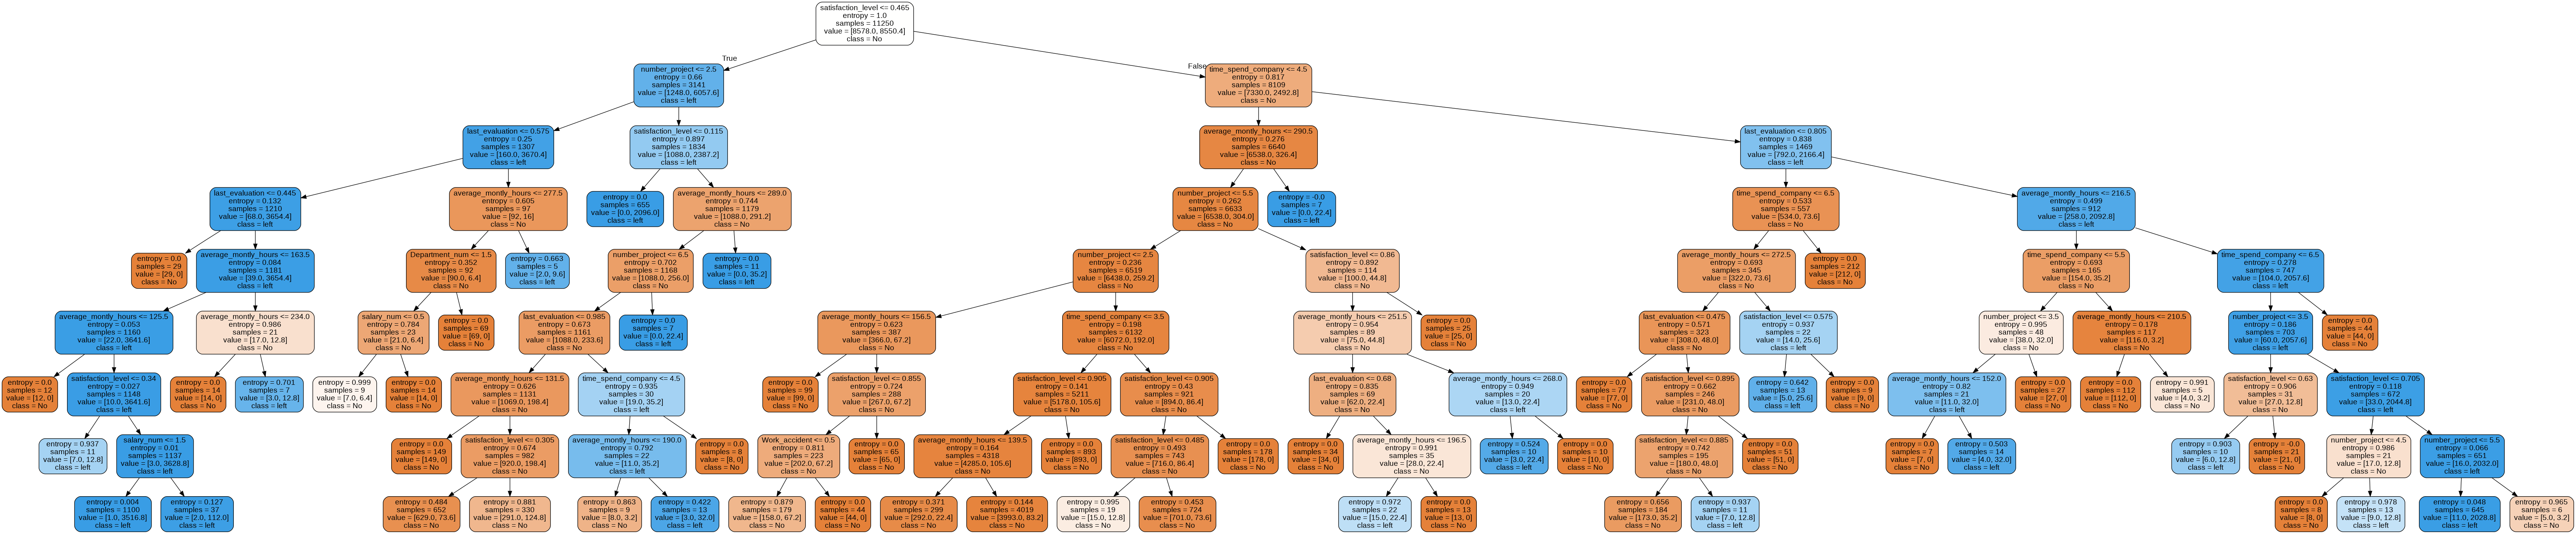

In [ ]:
# Crear arrays de entrenamiento y las etiquetas que indican si llegó a top o no 
#y_train = empleados_num['left']
#x_train = empleados_num.drop(['left'], axis=1).values 

# Crear Arbol de decision con profundidad = 8
decision_tree = tree.DecisionTreeClassifier(criterion='entropy',
                                            min_samples_split=20,
                                            min_samples_leaf=5,
                                            max_depth = 8,
                                            class_weight={1:3.2})
decision_tree.fit(X_train, y_train)

# exportar el modelo a archivo .dot
# DOT es un lenguaje descriptivo en texto plano. 
# Proporciona una forma simple de describir grafos entendible por humanos y computadoras. 
with open(r"tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 8,
                              impurity = True,
                              feature_names = list(empleados_num.drop(['left'], axis=1)),
                              class_names = ['No', 'left'],
                              rounded = True,
                              filled= True )
        
# Convertir el archivo .dot a png para poder visualizarlo
check_call(['dot','-Tpng',r'tree1.dot','-o',r'tree1.png'])
PImage("tree1.png")

In [ ]:
# Accuracy del modelo
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
print(acc_decision_tree)

97.89


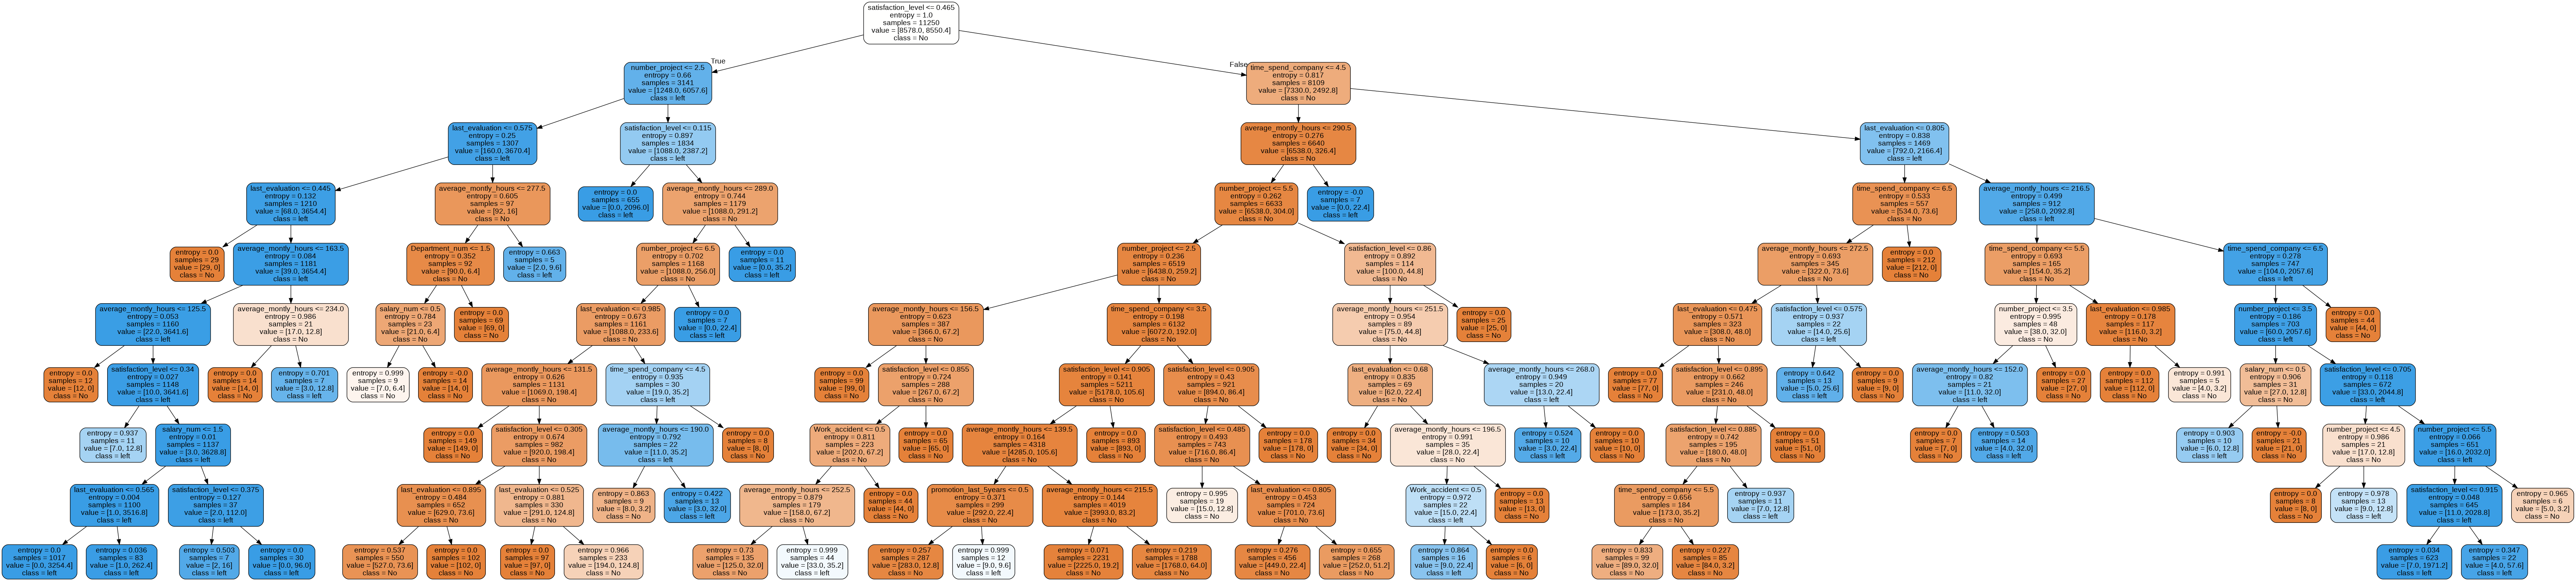

In [ ]:
# Crear arrays de entrenamiento y las etiquetas que indican si llegó a top o no 
#y_train = empleados_num['left']
#x_train = empleados_num.drop(['left'], axis=1).values 

# Crear Arbol de decision con profundidad = 9
decision_tree = tree.DecisionTreeClassifier(criterion='entropy',
                                            min_samples_split=20,
                                            min_samples_leaf=5,
                                            max_depth = 9,
                                            class_weight={1:3.2})
decision_tree.fit(X_train, y_train)

# exportar el modelo a archivo .dot
# DOT es un lenguaje descriptivo en texto plano. 
# Proporciona una forma simple de describir grafos entendible por humanos y computadoras. 
with open(r"tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 9,
                              impurity = True,
                              feature_names = list(empleados_num.drop(['left'], axis=1)),
                              class_names = ['No', 'left'],
                              rounded = True,
                              filled= True )
        
# Convertir el archivo .dot a png para poder visualizarlo
check_call(['dot','-Tpng',r'tree1.dot','-o',r'tree1.png'])
PImage("tree1.png")

In [ ]:
# Accuracy del modelo
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
print(acc_decision_tree)

97.7


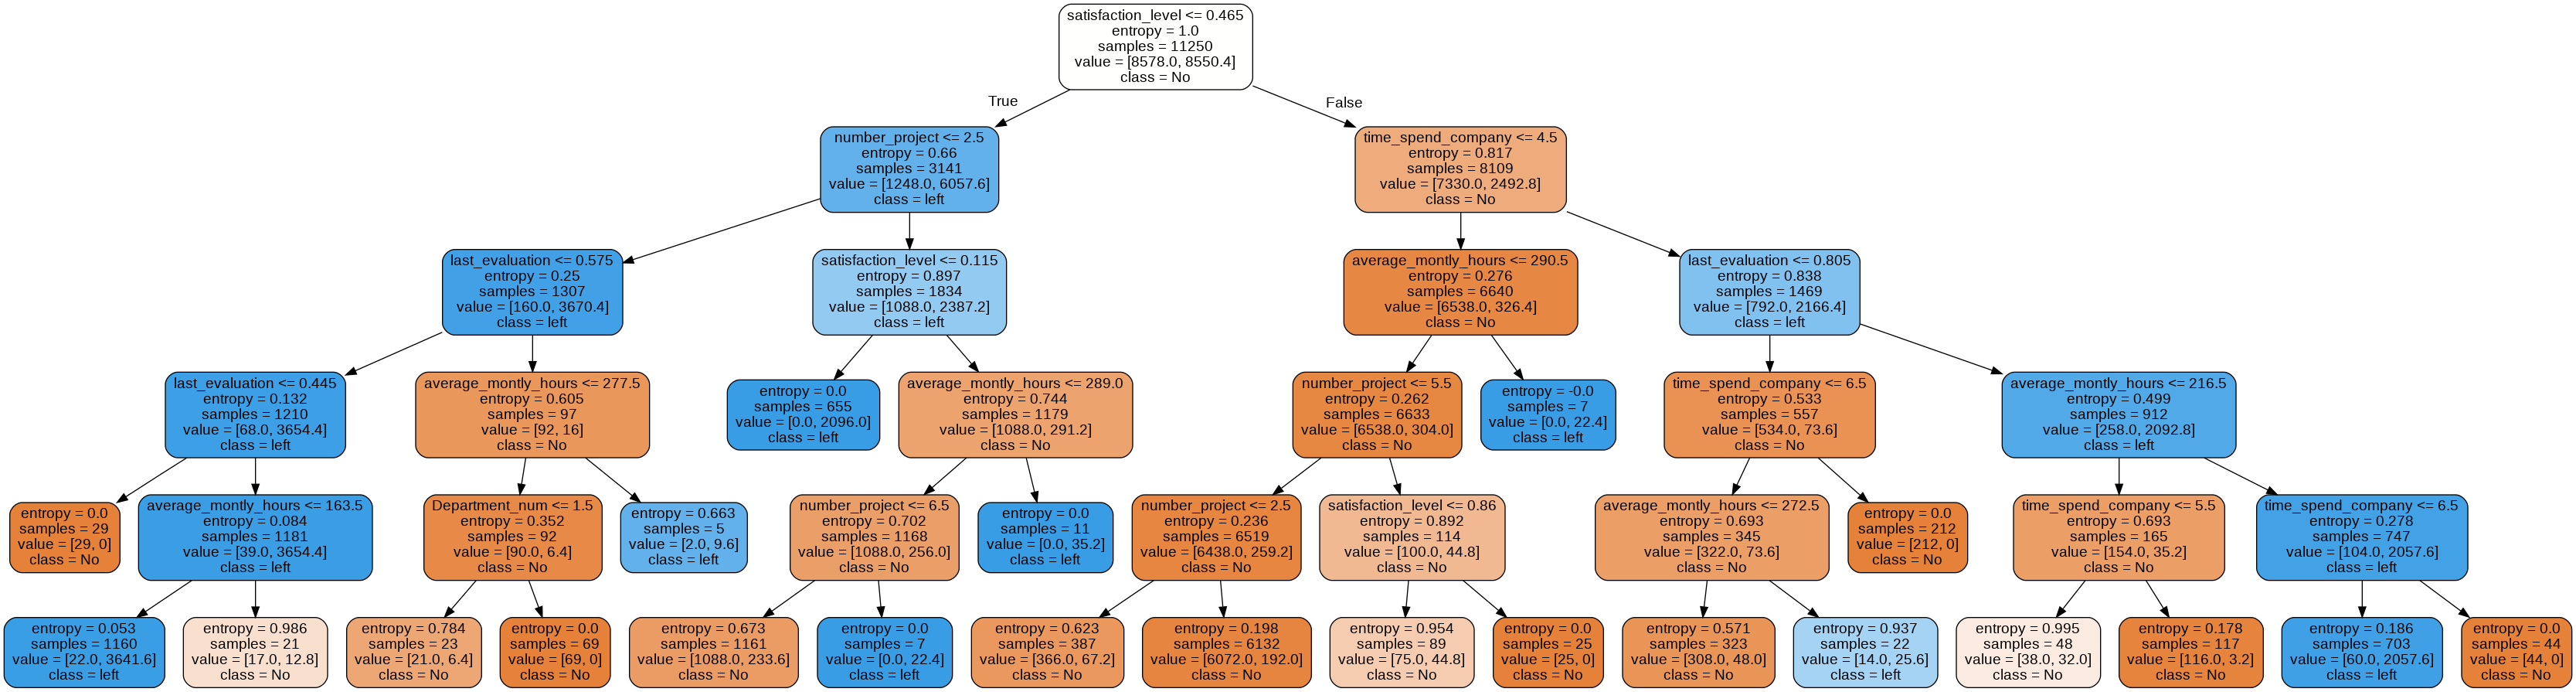

In [ ]:
# Crear arrays de entrenamiento y las etiquetas que indican si llegó a top o no 
#y_train = empleados_num['left']
#x_train = empleados_num.drop(['left'], axis=1).values 

# Crear Arbol de decision con profundidad = 5
decision_tree = tree.DecisionTreeClassifier(criterion='entropy',
                                            min_samples_split=20,
                                            min_samples_leaf=5,
                                            max_depth = 5,
                                            class_weight={1:3.2})
decision_tree.fit(X_train, y_train)

# exportar el modelo a archivo .dot
# DOT es un lenguaje descriptivo en texto plano. 
# Proporciona una forma simple de describir grafos entendible por humanos y computadoras. 
with open(r"tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 5,
                              impurity = True,
                              feature_names = list(empleados_num.drop(['left'], axis=1)),
                              class_names = ['No', 'left'],
                              rounded = True,
                              filled= True )
        
# Convertir el archivo .dot a png para poder visualizarlo
check_call(['dot','-Tpng',r'tree1.dot','-o',r'tree1.png'])
PImage("tree1.png")

In [ ]:
# Accuracy del modelo
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
print(acc_decision_tree)

97.35


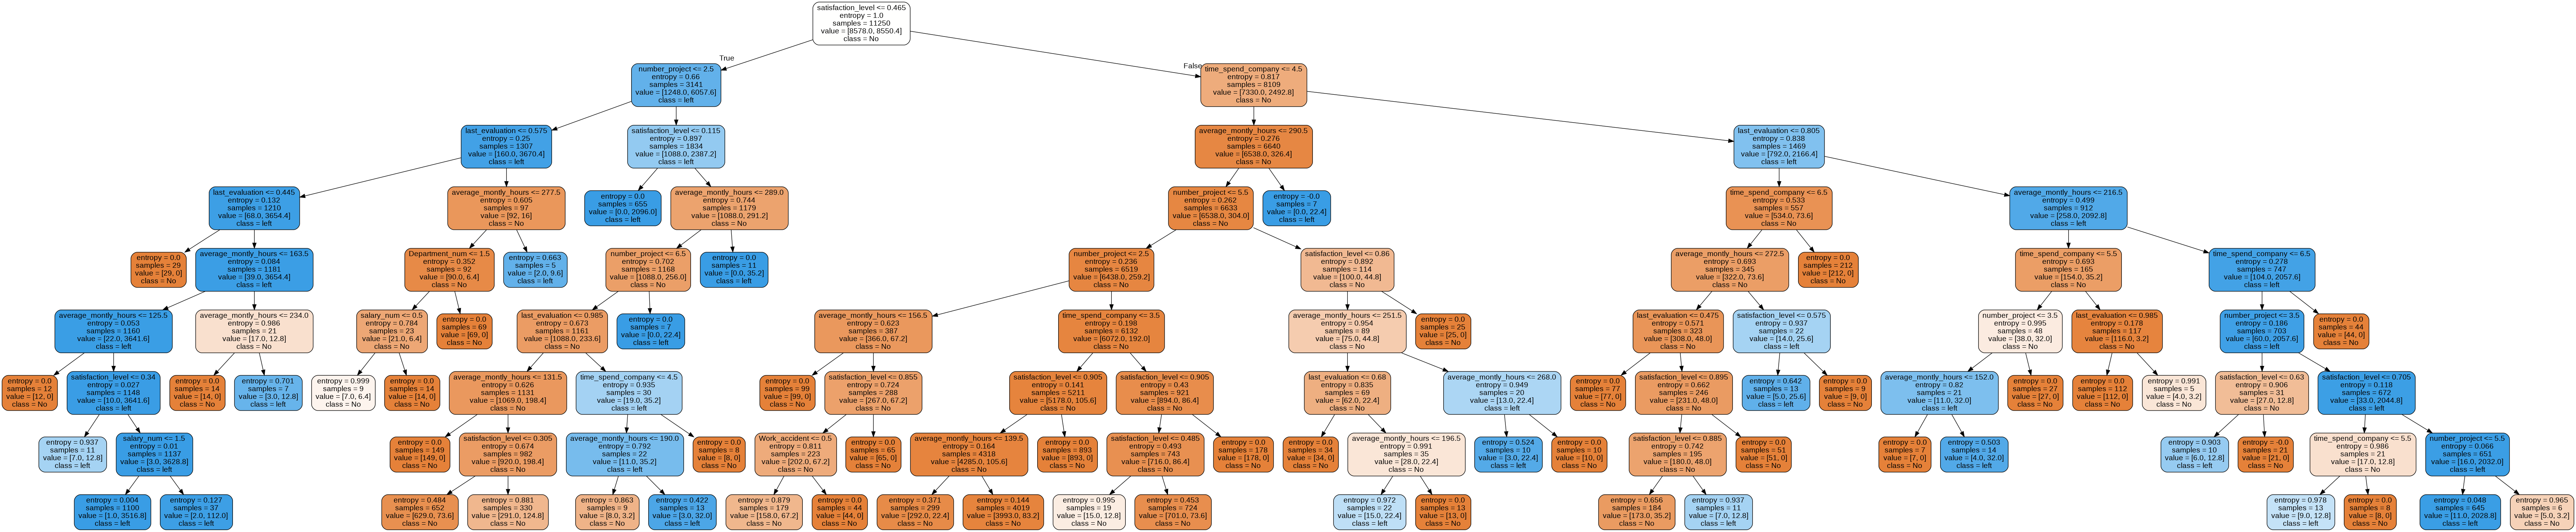

In [ ]:
# Crear arrays de entrenamiento y las etiquetas que indican si llegó a top o no 
#y_train = empleados_num['left']
#x_train = empleados_num.drop(['left'], axis=1).values 

# Crear Arbol de decision con profundidad = 8
decision_tree = tree.DecisionTreeClassifier(criterion='entropy',
                                            min_samples_split=20,
                                            min_samples_leaf=5,
                                            max_depth = 8,
                                            class_weight={1:3.2})
decision_tree.fit(X_train, y_train)

# exportar el modelo a archivo .dot
# DOT es un lenguaje descriptivo en texto plano. 
# Proporciona una forma simple de describir grafos entendible por humanos y computadoras. 
with open(r"tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 8,
                              impurity = True,
                              feature_names = list(empleados_num.drop(['left'], axis=1)),
                              class_names = ['No', 'left'],
                              rounded = True,
                              filled= True )
        
# Convertir el archivo .dot a png para poder visualizarlo
check_call(['dot','-Tpng',r'tree1.dot','-o',r'tree1.png'])
PImage("tree1.png")

In [ ]:
# Accuracy del modelo
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
print(acc_decision_tree)

97.89


In [ ]:
y_pred = decision_tree.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2817   34]
 [  52  847]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2851
           1       0.96      0.94      0.95       899

    accuracy                           0.98      3750
   macro avg       0.97      0.97      0.97      3750
weighted avg       0.98      0.98      0.98      3750



In [ ]:
#predecir si el empleado IND01034 dejará empleo
# Si lo dejó

x_test = pd.DataFrame(columns=('satisfaction_level','last_evaluation','number_project','average_montly_hours','time_spend_company', 'Work_accident','left', 'promotion_last_5_years','Department_num', 'salary_num'))
x_test.loc[0] = (0.1,0.89,7,272,4,0,1,0,3,2)
y_pred = decision_tree.predict(x_test.drop(['left'], axis = 1))
print("Prediccion: " + str(y_pred))
y_proba = decision_tree.predict_proba(x_test.drop(['left'], axis = 1))
print("Probabilidad de Acierto: " + str(round(y_proba[0][y_pred][0]* 100, 2))+"%")

Prediccion: [1]
Probabilidad de Acierto: 100.0%


In [ ]:
#predecir si el empleado IND0109 dejará empleo
# No lo dejó

x_test = pd.DataFrame(columns=('satisfaction_level','last_evaluation','number_project','average_montly_hours','time_spend_company', 'Work_accident','left', 'promotion_last_5_years','Department_num', 'salary_num'))
x_test.loc[0] = (0.48,0.67,3,183,2,0,0,0,1,1)
y_pred = decision_tree.predict(x_test.drop(['left'], axis = 1))
print("Prediccion: " + str(y_pred))
y_proba = decision_tree.predict_proba(x_test.drop(['left'], axis = 1))
print("Probabilidad de Acierto: " + str(round(y_proba[0][y_pred][0]* 100, 2))+"%")

Prediccion: [0]
Probabilidad de Acierto: 97.96%


In [ ]:
#predecir si el empleado IND1106 dejará empleo
# No lo dejó

x_test = pd.DataFrame(columns=('satisfaction_level','last_evaluation','number_project','average_montly_hours','time_spend_company', 'Work_accident','left', 'promotion_last_5_years','Department_num', 'salary_num'))
x_test.loc[0] = (0.59,0.83,3,240,3,1,0,0,4,2)
y_pred = decision_tree.predict(x_test.drop(['left'], axis = 1))
print("Prediccion: " + str(y_pred))
y_proba = decision_tree.predict_proba(x_test.drop(['left'], axis = 1))
print("Probabilidad de Acierto: " + str(round(y_proba[0][y_pred][0]* 100, 2))+"%")

Prediccion: [0]
Probabilidad de Acierto: 97.96%


In [ ]:
#predecir si el empleado IND01528 dejará empleo
# Si lo dejó

x_test = pd.DataFrame(columns=('satisfaction_level','last_evaluation','number_project','average_montly_hours','time_spend_company', 'Work_accident','left', 'promotion_last_5_years','Department_num', 'salary_num'))
x_test.loc[0] = (0.82,0.83,4,245,5,1,1,0,3,1)
y_pred = decision_tree.predict(x_test.drop(['left'], axis = 1))
print("Prediccion: " + str(y_pred))
y_proba = decision_tree.predict_proba(x_test.drop(['left'], axis = 1))
print("Probabilidad de Acierto: " + str(round(y_proba[0][y_pred][0]* 100, 2))+"%")

Prediccion: [1]
Probabilidad de Acierto: 99.46%


In [ ]:
#predecir si el empleado IND0158 dejará empleo
# No lo dejó

x_test = pd.DataFrame(columns=('satisfaction_level','last_evaluation','number_project','average_montly_hours','time_spend_company', 'Work_accident','left', 'promotion_last_5_years','Department_num', 'salary_num'))
x_test.loc[0] = (0.71,0.87,3,271,2,0,0,0,9,2)
y_pred = decision_tree.predict(x_test.drop(['left'], axis = 1))
print("Prediccion: " + str(y_pred))
y_proba = decision_tree.predict_proba(x_test.drop(['left'], axis = 1))
print("Probabilidad de Acierto: " + str(round(y_proba[0][y_pred][0]* 100, 2))+"%")

Prediccion: [0]
Probabilidad de Acierto: 97.96%


In [ ]:
#predecir si el empleado IND01633 dejará empleo
# No lo dejó

x_test = pd.DataFrame(columns=('satisfaction_level','last_evaluation','number_project','average_montly_hours','time_spend_company', 'Work_accident','left', 'promotion_last_5_years','Department_num', 'salary_num'))
x_test.loc[0] = (0.80,0.74,5,229,3,1,0,0,1,1)
y_pred = decision_tree.predict(x_test.drop(['left'], axis = 1))
print("Prediccion: " + str(y_pred))
y_proba = decision_tree.predict_proba(x_test.drop(['left'], axis = 1))
print("Probabilidad de Acierto: " + str(round(y_proba[0][y_pred][0]* 100, 2))+"%")

Prediccion: [0]
Probabilidad de Acierto: 97.96%
